# Saffman, M., et al. "Symmetric Rydberg controlled-Z gates with adiabatic pulses." Physical Review A 101.6 (2020): 062309.

In this simulation, we shape $\Omega1$ and let $\Omega2$, $\Delta1$ and $\Delta2$ be constants.

In [1]:
%cd /home/thc/Ubuntu_data/run_Saffman_shape-o1_fix-o2d1d2wLargerRange

/home/thc/Ubuntu_data/run_Saffman_shape-o1_fix-o2d1d2wLargerRange


In [2]:
from IPython.display import clear_output

from qutip import *
import math

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from rdquantum.pulse_shape import Saffman_shape
from rdquantum.fidelity import fidelity
from rdquantum.optimizer.de import de

# Physical system

In [3]:
### Hamiltonian ###
def Hamiltonian(shape_omega1, value_omega2, value_delta1, value_delta2):
    rho = []    # 0, 1, p, r, d
    for i in range(5):
        rho.append(ket2dm(basis(5,i)))

    I = qeye(5)

    H_omega1 = np.zeros((5,5))
    H_omega1[2][1] = 2*np.pi / 2
    H_omega1[1][2] = 2*np.pi / 2
    H_omega1 = Qobj(H_omega1)

    # Let Omega2, Delta1 and Delta2 be constants.
    H_omega2 = np.zeros((5,5))
    H_omega2[3][2] = 2*np.pi / 2 * value_omega2[0]
    H_omega2[2][3] = 2*np.pi / 2 * value_omega2[0]
    H_omega2 = Qobj(H_omega2)

    H_delta1 = np.zeros((5,5))
    H_delta1[2][2] = 2*np.pi * value_delta1[0]
    H_delta1 = Qobj(H_delta1)
    
    value_delta = value_delta1[0] + value_delta2[0]
    H_delta = np.zeros((5,5))
    H_delta[3][3] = 2*np.pi * value_delta
    H_delta = Qobj(H_delta)

    B = 2*np.pi * 500           # (MHz) Strength of Rydberg states interaction
    Brr = np.zeros((5,5))
    Brr[3][3] = np.sqrt(B)
    Brr = tensor(Qobj(Brr), Qobj(Brr))

    H = [[tensor(H_omega1, I) + tensor(I, H_omega1), shape_omega1], 
         [tensor(H_omega2, I) + tensor(I, H_omega2), '1'], 
         [tensor(H_delta1, I) + tensor(I, H_delta1), '1'], 
         [tensor(H_delta, I) + tensor(I, H_delta), '1'],
         [Brr, '1']]

    return H


### Pulse shape omega1(t), omega2(t) and delta1(t) ###
def PulseShape(times, Pulses, T_gate, n_seg):

    def shape_omega1(t, arg):
        return Saffman_shape(t, Pulses['Omega1'],T_gate, n_seg)

    value_omega2 = Pulses['Omega2']

    value_delta1 = Pulses['Delta1']
    
    value_delta2 = Pulses['Delta2']
    
    return shape_omega1, value_omega2, value_delta1, value_delta2


### Decay term, c_ops ###
def Decay(gammap=1/0.155, gammar=1/540):
    # gammap: (1/mu s) population decay rate of the Rydberg state
    # gammar: (1/mu s) population decay rate of the P state
    c_ops = []
    I = qeye(5)

    L0p = np.zeros((5,5))
    L0p[0][2] = np.sqrt(1/16 * gammap)
    c_ops.append(tensor(Qobj(L0p), I))
    c_ops.append(tensor(I, Qobj(L0p)))

    L0r = np.zeros((5,5))
    L0r[0][3] = np.sqrt(1/32 * gammar)
    c_ops.append(tensor(Qobj(L0r), I))
    c_ops.append(tensor(I, Qobj(L0r)))

    L1p = np.zeros((5,5))
    L1p[1][2] = np.sqrt(1/16 * gammap)
    c_ops.append(tensor(Qobj(L1p), I))
    c_ops.append(tensor(I, Qobj(L1p)))

    L1r = np.zeros((5,5))
    L1r[1][3] = np.sqrt(1/32 * gammar)
    c_ops.append(tensor(Qobj(L1r), I))
    c_ops.append(tensor(I, Qobj(L1r)))

    Ldp = np.zeros((5,5))
    Ldp[4][2] = np.sqrt(7/8 * gammap)
    c_ops.append(tensor(Qobj(Ldp), I))
    c_ops.append(tensor(I, Qobj(Ldp)))

    Ldr = np.zeros((5,5))
    Ldr[4][3] = np.sqrt(7/16 * gammar)
    c_ops.append(tensor(Qobj(Ldr), I))
    c_ops.append(tensor(I, Qobj(Ldr)))

    Lpr = np.zeros((5,5))
    Lpr[2][3] = np.sqrt(1/2 * gammar)
    c_ops.append(tensor(Qobj(Lpr), I))
    c_ops.append(tensor(I, Qobj(Lpr)))

    return c_ops


### Create two qubits state as density matrix, dm(control_qubit, target_qubit) ###
# def dm(control_qubit, target_qubit):
#     return ket2dm( tensor(basis(5, control_qubit), basis(5, target_qubit)) )

# Gate Operation

In [4]:
# Gate operation
def GateOp(Pulses, rho_init, targets):
    times = np.linspace(0.0, 1, 100)
    T_gate = 1              # (mu s) Total gate time
    n_seg = 2*len(Omega1)   # Number of segments

    shape_omega1, value_omega2, value_delta1, value_delta2 = PulseShape(times, Pulses, T_gate, n_seg)
    H = Hamiltonian(shape_omega1, value_omega2, value_delta1, value_delta2)
    c_ops = Decay(1/0.155, 1/540)
    
    results = mesolve(H, rho_init, times, c_ops, targets, options=Options(nsteps=10000))
    return results

# Outpout

In [5]:
Omega1 = [1.38, 10.30, 25.54, 42.85, 82.50, 93.35]
Omega2 = [175]
Delta1 = [300]
Delta2 = [300]
Pulses = {'Omega1': Omega1, 'Omega2': Omega2, 'Delta1': Delta1, 'Delta2': Delta2}
PulsesRange = {'Omega1': [0, 100], 'Omega2': [0, 200], 'Delta1': [-1250, 1250], 'Delta2': [-1250, 1250]}

Had = np.zeros((5,5))
Had[0][0] = 1
Had[0][1] = 1
Had[1][0] = 1
Had[1][1] = -1

I = qeye(5)
Had = Qobj(Had/np.sqrt(2))

ket00 = tensor(basis(5,0), basis(5,0))
ket01 = tensor(basis(5,0), basis(5,1))
ket10 = tensor(basis(5,1), basis(5,0))
ket11 = tensor(basis(5,1), basis(5,1))

# Target Bell state, rho_bell = 1/sqrt(2) * (|01> + |10>)
rho0101 = tensor(I, Had) * ket2dm(ket01) * tensor(I, Had)
rho1010 = tensor(I, Had) * ket2dm(ket10) * tensor(I, Had)
rho0110 = tensor(I, Had) * (ket10 * ket01.dag()) * tensor(I, Had)
rho_bell = [rho0101, rho1010, rho0110]

# Initial state, rhoi = |01><01|
rhoi = tensor(Had, Had) * ket2dm(ket01) * tensor(Had, Had)

bell_fidelity = fidelity(GateOp)
print(bell_fidelity.get_fidelity(Pulses, rhoi, rho_bell))

0.30408851404957277


# Differentail Evolution

In [6]:
K = len(Pulses)
# diffevo = de(bell_fidelity, K, 0, 500)
diffevo = de(bell_fidelity, rhoi, rho_bell)
diffevo.createPopulations(Pulses, PulsesRange)

In [30]:
diffevo.start(itr=4000, batch=10)

Number of control parameters: 9
Populations size: 135
Start differential evolution...
Iterations: 4000
Optimized fidelity: 0.9975967557401522
# 4000 batch iteration.

Fidelity (Ci, Di) = 0.997596752789415 0.9975967547396519, population 62 unchanged
Fidelity (Ci, Di) = 0.9975967538819801 0.9975967548446258, population 48 unchanged
Fidelity (Ci, Di) = 0.9975967530461107 0.9975967555446625, population 60 unchanged
Fidelity (Ci, Di) = 0.9975799746182671 0.9975967553931167, population 134 unchanged
Fidelity (Ci, Di) = 0.9975936026343677 0.9975967555446625, population 60 unchanged
Fidelity (Ci, Di) = 0.9975967527184972 0.9975967546426199, population 59 unchanged
Fidelity (Ci, Di) = 0.9975967534308092 0.9975967547655986, population 80 unchanged
Fidelity (Ci, Di) = 0.9975922094194483 0.9975967547396519, population 62 unchanged
Fidelity (Ci, Di) = 0.9975965939506661 0.9975967548637588, population 102 unchanged
Optimized Fidelity: 0.9975967557401522 0.9975967545556677, population 78 unchanged


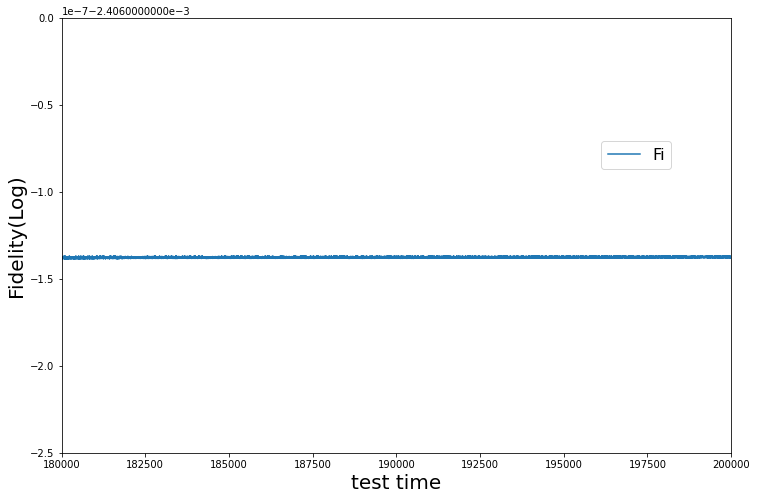

In [47]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(np.log(diffevo.data_fidelity), label="Fi")
# ax1.plot(diffevo.data_fidelity, label="Fi")

ax1.set_xlabel("test time", fontsize=20) 
ax1.set_ylabel("Fidelity(Log)", fontsize=20)

plt.ylim([-0.00240625, -0.002406])
plt.xlim([180000, 200000])

fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)

In [9]:
# testnpy = np.load("out.npz")

In [50]:
print(diffevo.populations)

[{'Omega1': [0.46096531884401537, 17.764381577614422, 22.82673429741667, 46.77625936782636, 79.54839269252483, 99.99998713028815], 'Omega2': [199.99999841982162], 'Delta1': [-356.3334881334832], 'Delta2': [356.3756545658639]}, {'Omega1': [0.4554091845504823, 17.73203044804514, 22.824393483844226, 46.754150527212914, 79.55239558717304, 99.99997712834646], 'Omega2': [199.99999234240568], 'Delta1': [-356.32015514138925], 'Delta2': [356.3623578789078]}, {'Omega1': [0.46073699528303746, 17.73303246035495, 22.841912442584906, 46.761752945589215, 79.54917871959174, 99.99994915237625], 'Omega2': [199.99999553372814], 'Delta1': [-356.320438310687], 'Delta2': [356.36264011284675]}, {'Omega1': [0.45271515978913796, 17.757305184072337, 22.835906705848068, 46.75304733716301, 79.55225011962396, 99.99995640924237], 'Omega2': [199.99999594367125], 'Delta1': [-356.321853698306], 'Delta2': [356.3641214599242]}, {'Omega1': [0.4608709617877491, 17.738394129012274, 22.83227866813396, 46.768224540995384, 79

In [51]:
print(diffevo.op_pulse)

{'Omega1': [0.4609955801390644, 17.729168255232945, 22.824515947915962, 46.76334374503912, 79.55061346231209, 99.99996022750652], 'Omega2': [199.99999997611695], 'Delta1': [-356.3231205662065], 'Delta2': [356.3653695461566]}


In [52]:
# Pulse shape
T_gate = 1          # (mu s) Total gate time
n = 12   # Number of segments
dt = T_gate/n       # (mu s) Duration of each segment
def Pshape(t, pulse_coe):
        ith = int( (t - dt/2) // dt )
        ti = dt/2 + dt*ith
        ti1 = ti + dt
        
        if t < dt/2 or t > (T_gate - dt/2):
            fi = pulse_coe[0]
            fi1 = pulse_coe[0]
            ft = (fi + fi1)/2 

        else:
            if ith < 5:
                ith1 = ith + 1
                fi = pulse_coe[ith]
                fi1 = pulse_coe[ith1]
                ft = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

            elif ith == 5:
                ith1 = ith
                fi = pulse_coe[ith]
                fi1 = pulse_coe[ith1]
                ft = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

            elif ith > 5:
                ith1 = ith + 1
                fi = pulse_coe[n-ith-1]
                fi1 = pulse_coe[n-ith1-1]
                ft  = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

        return ft

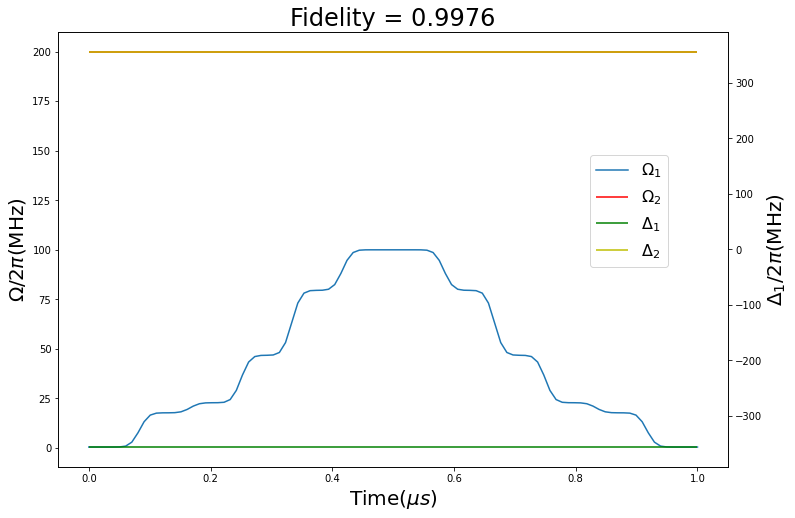

In [45]:
Omega1 = diffevo.op_pulse['Omega1']
Omega2 = diffevo.op_pulse['Omega2'][0]
Delta1 = diffevo.op_pulse['Delta1'][0]
Delta2 = diffevo.op_pulse['Delta2'][0]
times = np.linspace(0.0, 1, 100)

pulse_Omega1 = []

for t in times:
    pulse_Omega1.append( Pshape(t, Omega1))
    # pulse_Omega2.append( Pshape(t, Omega2))
    # delta1.append( Pshape(t, Delta1))

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(times, pulse_Omega1, label=r'$\Omega_1$')
ax1.hlines(y=Omega2, xmin=0, xmax=1, label=r'$\Omega_2$', color='r')

ax2 = ax1.twinx()
ax2.hlines(y=Delta1, xmin=0, xmax=1, label=r'$\Delta_1$', color='g')
ax2.hlines(y=Delta2, xmin=0, xmax=1, label=r'$\Delta_2$', color='y')

ax1.set_xlabel('Time' r'$(\mu s)$', fontsize=20) 
ax1.set_ylabel(r'$\Omega / 2 \pi$' '(MHz)', fontsize=20)
ax2.set_ylabel(r'$\Delta_1 / 2 \pi$' '(MHz)', fontsize=20)

plt.title("Fidelity = %.4f" %diffevo.op_fidelity, fontsize=24)
fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)

In [13]:
print(Delta1)

-336.76868150850675


# Population evo

In [14]:
# Target Bell state, rho_bell = 1/sqrt(2) * (|01> + |10>)
rho1111 = tensor(I, Had) * ket2dm(ket11) * tensor(I, Had)
rho0000 = tensor(I, Had) * ket2dm(ket00) * tensor(I, Had)
rho1010 = tensor(I, Had) * (ket10 * ket10.dag()) * tensor(I, Had)
rho_bell = [rho1111, rho0000, rho1010]

# Initial state, rhoi = |01><01|
rhoi = tensor(Had, Had) * ket2dm(ket11) * tensor(Had, Had)

op_pulse = diffevo.op_pulse

bell_fidelity = fidelity(GateOp)
print(bell_fidelity.get_fidelity(op_pulse, rhoi, rho_bell))

0.4975140876040681


In [15]:
# # Target Bell state, rho_bell = 1/sqrt(2) * (|01> + |10>)
# rho0101 = tensor(I, Had) * ket2dm(ket01) * tensor(I, Had)
# rho1010 = tensor(I, Had) * ket2dm(ket10) * tensor(I, Had)
# rho0110 = tensor(I, Had) * (ket10 * ket01.dag()) * tensor(I, Had)
# rho_bell = [rho0101, rho1010, rho0110]

# # Initial state, rhoi = |01><01|
# rhoi = tensor(Had, Had) * ket2dm(ket01) * tensor(Had, Had)

op_pulse = diffevo.op_pulse

rho10 = ket2dm(ket10)
rhor0 = ket2dm(tensor(basis(5,3), basis(5,0)))
rhod0 = ket2dm(tensor(basis(5,4), basis(5,0)))

test_targets = [rho10, rhor0, rhod0]

result = GateOp(op_pulse, rhoi, test_targets)

<ipython-input-16-a4d026927be8>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(times, np.log10(result.expect[1]))
<ipython-input-16-a4d026927be8>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(times, np.log10(result.expect[2]))


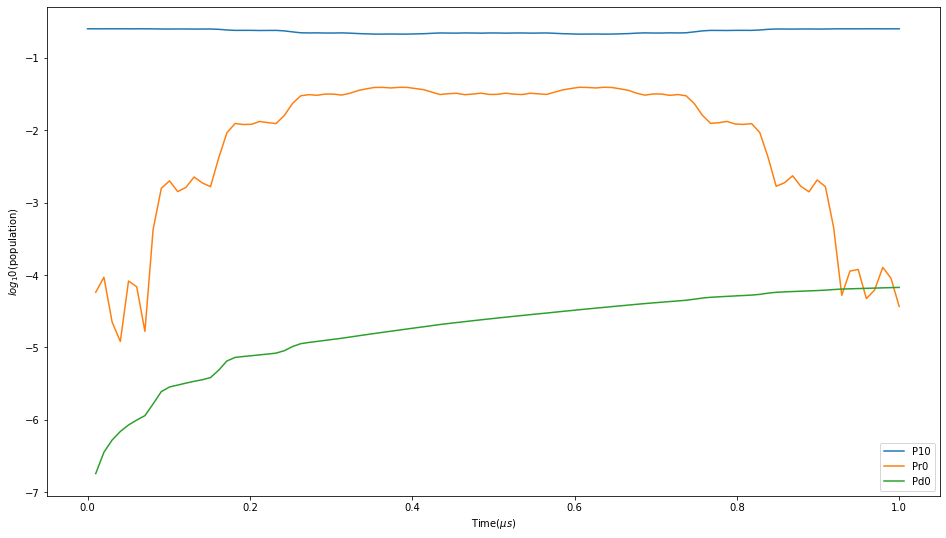

In [16]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times, np.log10(result.expect[0])) 
ax.plot(times, np.log10(result.expect[1]))
ax.plot(times, np.log10(result.expect[2]))
ax.set_xlabel('Time' r'$(\mu s)$') 
ax.set_ylabel(r'$log_10$' '(population)') 
ax.legend(("P10", "Pr0", "Pd0"))
plt.show()